# Atlas-level integration

In this tutorial, I will cover some tips and tricks for modeling large collections of single-cells using a scATAC-seq atlas of brain development, originally published in [Trevino et al., 2021](https://www.cell.com/cell/fulltext/S0092-8674(21)00942-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867421009429%3Fshowall%3Dtrue). This dataset consists of ~30K cells, some of which were measured with standard scATAC-seq and some of which were measured in a different batch using single-cell multiome ATAC+RNA-seq. 

One key problem when working with large-scale atlases is it can be hard to know how many topics will best represent the dataset - complex systems could require many tens of topics to capture all of the apparaent heterogeneity. Even though we provide an automated method for determining this, Bayesian search of extremely large ranges is time consuming and inefficient. In this tutorial, I demonstrate how to use gradient descent to estimate the number of topics in a dataset using a Dirichlet Process model.

First, import some packages:

In [1]:
import scanpy as sc
import anndata
import pandas as pd
import seaborn as sns
import numpy as np
import mira
import matplotlib.pyplot as plt
import torch

mira.__version__

'2.0.0a1'

Since we're training an accessibility model in this tutorial, we want to make sure we are working on a GPU:

In [2]:
assert torch.cuda.is_available()

Now, load some data:

In [3]:
data = anndata.read_h5ad('data/greenleaf_brain_tutorial/atac_data.h5ad')
sc.pp.filter_cells(data, max_counts=15000)

data

AnnData object with n_obs × n_vars = 30412 × 334373
    obs: 'n_genes_by_counts', 'total_counts', 'batch', 'Iterative.LSI.Clusters', 'Age', 'seurat_clusters', 'Sample.Age', 'age', 'n_counts'
    var: 'n_counts'
    uns: 'Age_colors', 'Sample.Age_colors', 'age_colors', 'batch_colors', 'neighbors', 'umap'
    obsm: 'X_lsi', 'X_umap'
    obsp: 'connectivities', 'distances'

This dataset consists of 30K cells and over 300K peaks. That's a lot of peaks! There are also pretty drastic batch effects confounding joint analysis of the multiome and standard data:

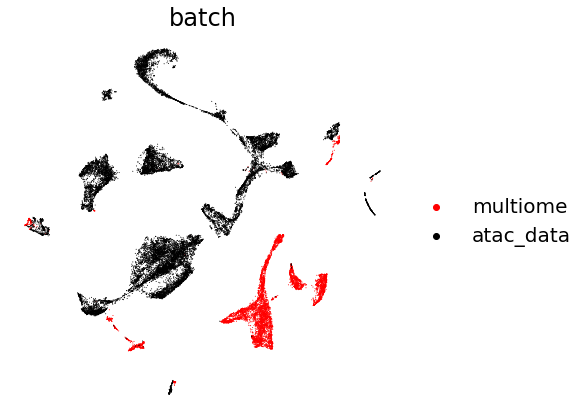

In [4]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
sc.pl.umap(data, color = 'batch', frameon = False, palette=['red','black'], ax = ax)

This looks like a good application for CODAL. To save memory when training accessibility topic models, one can randomly downsample the peaks modeled by the encoder network to around ~100K peaks without hurting performance. If you pass this column to `endogenous_key`, the peaks will still be modeled by the likelihood function.

In [3]:
np.random.seed(0)
data.var['endogenous_peaks'] = np.random.rand(data.n_vars) < 1/3

## Estimating Num Topics using Dirichlet Process modeling

As in the previous tutorial, we can instantiate a topic model, but this time we specify `latent_space = 'dp'`, which tells MIRA to build a model with a Dirichlet Process *(DP)* prior over the latent variables.

The Dirichlet Process model automatically selects the number of topics to use during training. It requires more data for training than normal topic models and produces worse representations, but as a tool to quickly estimate the number of topics in a dataset, it is very useful. **I recommend only applying the DP model to datasets with >30K cells, and only using it as a first-pass model.** For smaller datasets, just estimate the number of topics using the standard Bayesian hyperparameter optimization scheme.

In [4]:
model = mira.topics.TopicModel(
    *data.shape,
    feature_type = 'accessibility',
    categorical_covariates='batch',
    endogenous_key= 'endogenous_peaks',
    exo
    latent_space = 'dp', # Use Dirichlet Process prior
)

For smaller datasets, please use the "dirichlet" latent space, and use the tunerto find the optimal number of topics.


Now we arrive at the first tip for working with large datasets, which is to manually write training and testing chunks of cells to disk to reduce memory overhead:

In [47]:
train, test = model.train_test_split(data)

model.write_ondisk_dataset(train, dirname='data/greenleaf_brain_tutorial/atac_train')
model.write_ondisk_dataset(test, dirname='data/greenleaf_brain_tutorial/atac_test')

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: endogenous_peaks


Writing dataset to disk:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: endogenous_peaks


Writing dataset to disk:   0%|          | 0/6 [00:00<?, ?it/s]

Now continue as normal, but instead of supplying `anndata` objects to each method, you can pass a file location for some on-disk cache:

In [48]:
model.get_learning_rate_bounds('data/greenleaf_brain_tutorial/atac_train')

Gathering dataset statistics:   0%|          | 0/24329 [00:00<?, ?it/s]

Learning rate range test:   0%|          | 0/98 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (5.303396870926118e-06, 0.11875003918010227)


(5.303396870926118e-06, 0.11875003918010227)

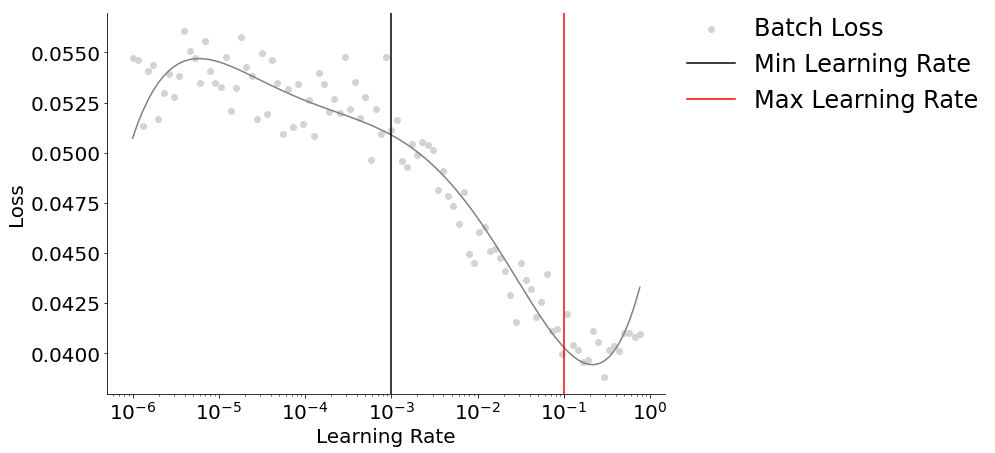

In [50]:
model.set_learning_rates(1e-3, 0.1)
ax = model.plot_learning_rate_bounds()

With the learning rate selected, we can move to training for the DP model, again passing the file location of the on-disk cache:

In [9]:
model.fit('data/greenleaf_brain_tutorial/atac_train')

Gathering dataset statistics:   0%|          | 0/30412 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu


dirichlet-process_accessibility_covariate-model(
  (decoder): Decoder(
    (beta): Linear(in_features=70, out_features=111651, bias=False)
    (bn): BatchNorm1d(111651, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.05, inplace=False)
    (drop2): Dropout(p=0.1, inplace=False)
    (batch_effect_model): Sequential(
      (0): ConcatLayer()
      (1): Sequential(
        (0): Linear(in_features=72, out_features=32, bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.05, inplace=False)
      )
      (2): Linear(in_features=32, out_features=111651, bias=True)
      (3): BatchNorm1d(111651, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
  )
  (encoder): DP_AccessibilityEncoder(
    (embedding): Embedding(111652, 256, padding_idx=0)
    (fc_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=259, out_featur

In [13]:
model.save('data/greenleaf_brain_tutorial/dp_model.pth')

In [55]:
model = mira.topics.load_model('data/greenleaf_brain_tutorial/dp_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


After training, calculate the topics:

In [56]:
model.predict(data)

Predicting latent vars:   0%|          | 0/119 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30, topic_31, topic_32, topic_33, topic_34, topic_35, topic_36, topic_37, topic_38, topic_39, topic_40, topic_41, topic_42, topic_43, topic_44, topic_45, topic_46, topic_47, topic_48, topic_49, topic_50, topic_51, topic_52, topic_53, topic_54, topic_55, topic_56, topic_57, topic_58, topic_59, topic_60, topic_61, topic_62, topic_63, topic_64, topic_65, topic_66, topic_67, topic_68, topic_69
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Then plot the maximum composition across cells that each topic was allocated. You may notice that while the model was instantiated with more than 60 topics available (a purposeful overshoot), only ~27 were actually allocated probability mass in the posterior. Unfortunately, it is difficult to quantify uncertainty about this estimate, but hueristically, this dataset probably contains 27±5 topics.

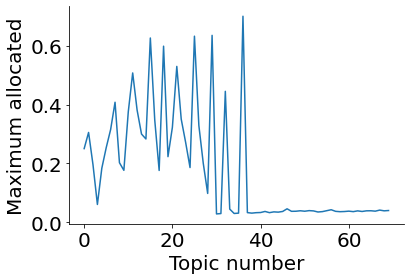

In [58]:
ax = sns.lineplot(y = data.obsm['X_topic_compositions'].max(0), 
             x = range(model.num_topics))
ax.set(ylabel = 'Maximum allocated', xlabel = 'Topic number')
sns.despine()

Okay! That narrows it down quite a bit. Now let's refine that estimate using the standard Bayesian hyperparameter optimization scheme. Use the `get_topic_model()` method, which transfers all of the parameters and setup we did to a fresh "topic model", in this case the standard CODAL/MIRA model with a hierarchical dirichlet prior over the latent variables. Set the minimum and maxmimum bounds comfortably around 27. 

In [9]:
tuner = mira.topics.SpeedyTuner(
    model = model.get_topic_model(),
    min_topics = 23,
    max_topics = 35,
    save_name = 'brain/atac/tuning/0',
)

Again, provide file locations for on-disk caches. This time, the tuner needs access to both the training and testing cache. Don't mix up the order!!!

In [13]:
tuner.fit('data/greenleaf_brain_tutorial/atac_train', 
          'data/greenleaf_brain_tutorial/atac_test')

ERROR:mira.topic_model.hyperparameter_optim.trainer:Optimal # of topics was very close to the minimum topics boundary! Please decrease "min_topics" and re-tune.
INFO:mira.topic_model.hyperparameter_optim.trainer:Deleting cache ...


Trials finished: 33 | Best trial: 13 | Best score: 8.4457e+03
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

Tensorboard logidr: runs/brain/atac/tuning/0
#Topics | #Trials 

     23 | ■ ■ 
     24 | ■ 
     25 | ■ ■ 
     26 | ■ ■ ■ 
     27 | ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
     28 | ■ ■ 
     29 | ■ 
     30 | ■ 
     31 | ■ ■ 
     33 | ■ 
     34 | ■ ■ ■ 

Trial | Result (● = best so far)         | Params
 #0   | ● | completed, score: 8.4530e+03 | {'num_topics': 34, 'decoder_dropout': 0.0709}
 #1   |   | pruned at step: 8            | {'num_topics': 30, 'decoder_dropout': 0.0668}
 #2   | ● | completed, score: 8.4486e+03 | {'num_topics': 31, 'decoder_dropout': 0.0790}
 #3   | ● | completed, score: 8.4466e+03 | {'num_topics': 26, 'decoder_dropout': 0.0552}
 #4   |   | pruned at step: 8            | {'num_topics': 33, 'decoder_dropout': 0.0636}
 #5   |   | pruned at step: 8            | {'num_topics': 28, 'decoder_dropout': 0.0583}
 #6   |   | pruned at step: 8   

dirichlet_accessibility_covariate-model(
  (decoder): Decoder(
    (beta): Linear(in_features=24, out_features=111651, bias=False)
    (bn): BatchNorm1d(111651, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.05, inplace=False)
    (drop2): Dropout(p=0.07529555822344842, inplace=False)
    (batch_effect_model): Sequential(
      (0): ConcatLayer()
      (1): Sequential(
        (0): Linear(in_features=26, out_features=32, bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.05, inplace=False)
      )
      (2): Linear(in_features=32, out_features=111651, bias=True)
      (3): BatchNorm1d(111651, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
  )
  (encoder): DANSkipEncoder(
    (embedding): Embedding(111652, 256, padding_idx=0)
    (embedding_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Very nice! The Bayesian hyperparameter optimizer also seems to favor 27 as a good number of topics to represent the dataset. In fact, the very best model found only had 24 topics, but from the pareto front plot this appears to be a bit of an outlier. In the case where many models seem to support one number of topics, but the very best model supports another, I usually choose the best model from the majority. 

<AxesSubplot:xlabel='Num_topics', ylabel='Elbo'>

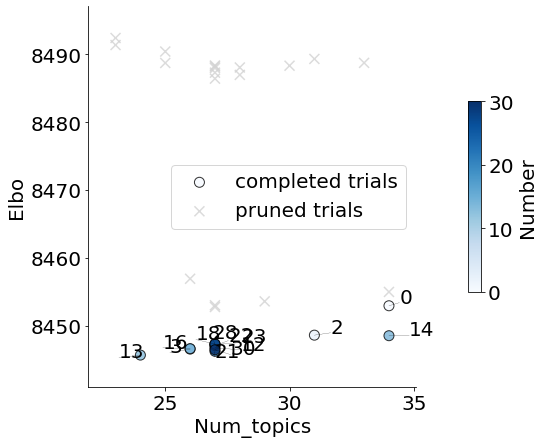

In [43]:
tuner.plot_pareto_front(include_pruned_trials=True)

In [17]:
topicmodel = tuner.fetch_weights(21)

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [18]:
topicmodel.predict(data)

Predicting latent vars:   0%|          | 0/119 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


In [21]:
model.get_umap_features(data, box_cox=0.5, add_key='X_umap_features_topicmodel')
sc.pp.neighbors(data, use_rep='X_umap_features_topicmodel', metric='manhattan') 
sc.tl.umap(data, min_dist=0.1)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.topic_model.base:Found 27 topics from the data.
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features_topicmodel


Finally, let's check out the representation. Coloring by batch with the multiome data in *red*, we can see the multiome and standard scATAC-seq are now well-mixed. 

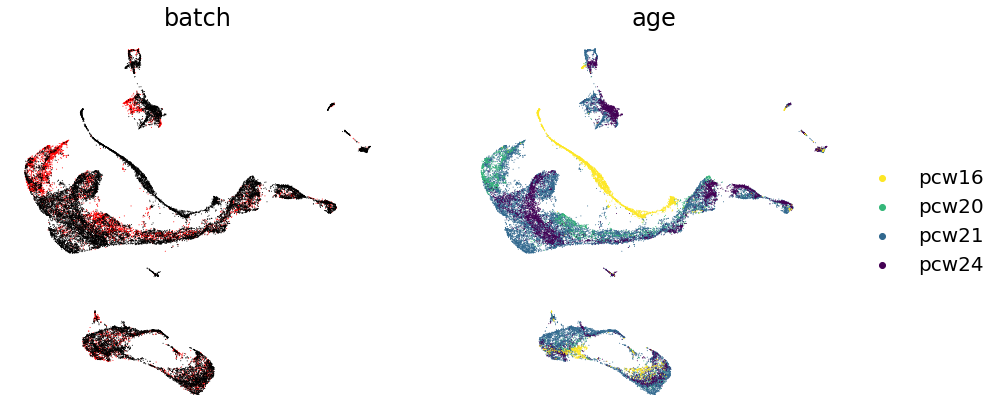

In [42]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
sc.pl.umap(data, color = 'batch', ax = ax[0], frameon=False, palette=['red','black'], legend_loc=None, show=False)
sc.pl.umap(data, color = 'age', ax = ax[1], frameon=False, palette='viridis_r')